# Learning  autoencoders  and GANs
## Based on Chap 17 of Hands on ML 3rd ed

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Utility function to plot grayscale 28x28 images
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## PCA with a linear autoencoder

In [3]:
# Build a 3D dataset

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# 2 subcomponents
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
# number of outputs of autoencoder = number of inputs (3)
# For PCA - no activation (linear neurons) and MSE as cost function

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 1s 18ms/sample - loss: 0.2561
Epoch 2/20
60/60 [==============================] - 0s 216us/sample - loss: 0.1258
Epoch 3/20
60/60 [==============================] - 0s 133us/sample - loss: 0.2229
Epoch 4/20
60/60 [==============================] - 0s 133us/sample - loss: 0.1502
Epoch 5/20
60/60 [==============================] - 0s 216us/sample - loss: 0.0436
Epoch 6/20
60/60 [==============================] - 0s 100us/sample - loss: 0.0401
Epoch 7/20
60/60 [==============================] - 0s 133us/sample - loss: 0.0344
Epoch 8/20
60/60 [==============================] - 0s 183us/sample - loss: 0.0195
Epoch 9/20
60/60 [==============================] - 0s 116us/sample - loss: 0.0124
Epoch 10/20
60/60 [==============================] - 0s 150us/sample - loss: 0.0096
Epoch 11/20
60/60 [==============================] - 0s 175us/sample - loss: 0.0093
Epoch 12/20
60/60 [==============================] - 0s 133us/samp

In [6]:
# To get the encodings
codings = encoder.predict(X_train)

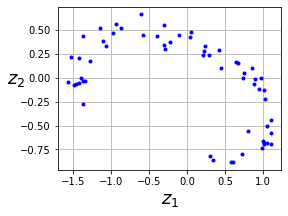

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked autoencoders

### Using MNIST fashion dataset

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
# Code for stacked autoencoder
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    # input 28*28 = 784, reduce to layers of 100 and 30
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    # From 30 to 100, then back to 784 then 28*28
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
# Treat the reconstruction as multilabel binary classification problem
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 134us/sample - loss: 0.3376 - rounded_accuracy: 0.8874 - val_loss: 0.3113 - val_rounded_accuracy: 0.9124
Epoch 2/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.3053 - rounded_accuracy: 0.9154 - val_loss: 0.3027 - val_rounded_accuracy: 0.9195
Epoch 3/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2988 - rounded_accuracy: 0.9212 - val_loss: 0.2980 - val_rounded_accuracy: 0.9217
Epoch 4/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2950 - rounded_accuracy: 0.9248 - val_loss: 0.2983 - val_rounded_accuracy: 0.9253
Epoch 5/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2934 - val_rounded_accuracy: 0.9254
Epoch 6/20
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2905 - rounded_accuracy: 0.9288 - val

In [6]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

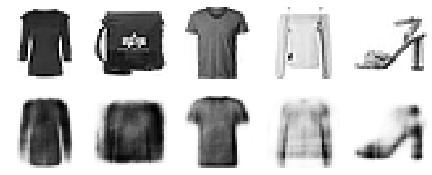

In [13]:
show_reconstructions(stacked_ae)

### Visualization

In [14]:
# Use TSNE to show clusters
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

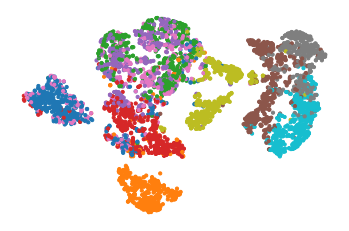

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

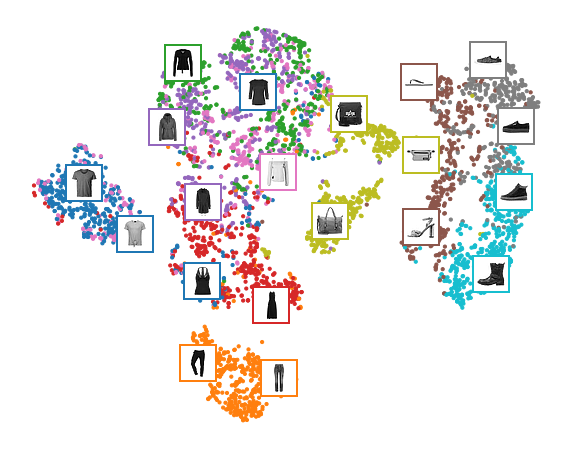

In [17]:
# Prettier visualization
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Tying weights

In [5]:
# Transpose the weight of encoder for decoder when the autoencoder is neatly symmetrical
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        # Transpose the weights but use it's own bias vector
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [6]:
# This line is useful when making multiple models in succession eg. cross validation or hyperparameter tuning. Removes all leftover nodes from prev models
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

# new stacked autoencoder but with encoder weights tied to decoder
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    # Weight tying here
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3269 - rounded_accuracy: 0.8959 - val_loss: 0.3025 - val_rounded_accuracy: 0.9191
Epoch 2/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2973 - rounded_accuracy: 0.9225 - val_loss: 0.2951 - val_rounded_accuracy: 0.9235
Epoch 3/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2915 - rounded_accuracy: 0.9280 - val_loss: 0.2930 - val_rounded_accuracy: 0.9242
Epoch 4/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2885 - rounded_accuracy: 0.9305 - val_loss: 0.2881 - val_rounded_accuracy: 0.9328
Epoch 5/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2863 - rounded_accuracy: 0.9326 - val_loss: 0.2892 - val_rounded_accuracy: 0.9268
Epoch 6/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2849 - rounded_accuracy: 0.9338 - val

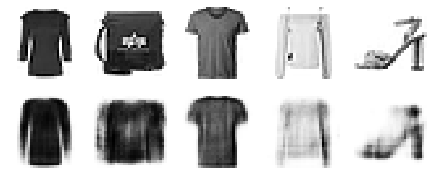

In [9]:
show_reconstructions(tied_ae)
plt.show()

### Train one autoencoder at a time
Rather than train the whole stacked AE in one go, train one shallow autoencoder at a time, then stack onto a single one

In [10]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
# Stack the outputs of the first autoencoder
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 118us/sample - loss: 0.3446 - rounded_accuracy: 0.8874 - val_loss: 0.3122 - val_rounded_accuracy: 0.9147
Epoch 2/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3040 - rounded_accuracy: 0.9203 - val_loss: 0.3007 - val_rounded_accuracy: 0.9244
Epoch 3/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.2950 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9310
Epoch 4/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.2892 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9359
Epoch 5/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.2855 - rounded_accuracy: 0.9377 - val_loss: 0.2858 - val_rounded_accuracy: 0.9386
Epoch 6/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2828 - rounded_accuracy: 0.9402 - val

In [12]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

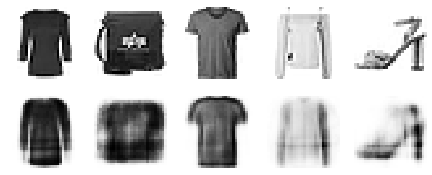

In [13]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [14]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 140us/sample - loss: 0.2852 - rounded_accuracy: 0.9360 - val_loss: 0.2868 - val_rounded_accuracy: 0.9359
Epoch 2/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.2849 - rounded_accuracy: 0.9364 - val_loss: 0.2866 - val_rounded_accuracy: 0.9360
Epoch 3/10
55000/55000 [==============================] - 7s 121us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2864 - val_rounded_accuracy: 0.9361
Epoch 4/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2845 - rounded_accuracy: 0.9368 - val_loss: 0.2863 - val_rounded_accuracy: 0.9365
Epoch 5/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9365
Epoch 6/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2842 - rounded_accuracy: 0.9370 - val

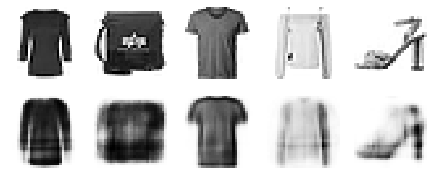

In [15]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional autoencoders
Normal autoencoders won't work for images unless they are very small. Use convolutional layers

In [16]:
# Reduces spatial dimensionality (height, width), but increases the depth (feature maps). Decoder do the reverse
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    # no padding for the first of the reverse
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 66s 1ms/sample - loss: 0.3020 - rounded_accuracy: 0.9186 - val_loss: 0.2801 - val_rounded_accuracy: 0.9394
Epoch 2/5
55000/55000 [==============================] - 66s 1ms/sample - loss: 0.2755 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9458
Epoch 3/5
55000/55000 [==============================] - 67s 1ms/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2705 - val_rounded_accuracy: 0.9472
Epoch 4/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2676 - val_rounded_accuracy: 0.9515
Epoch 5/5
55000/55000 [==============================] - 65s 1ms/sample - loss: 0.2663 - rounded_accuracy: 0.9510 - val_loss: 0.2661 - val_rounded_accuracy: 0.9534


In [17]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

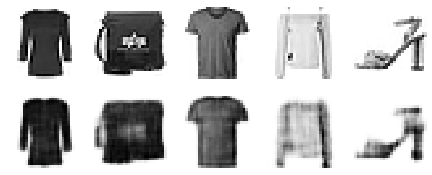

In [18]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent autoencoders
For sequences such as time series or text

In [19]:
# Basically a sequence to vector RNN which compresses input sequence to single vector
# Can process sequences of any length with 28 dimensions per time step
# Process MNIST images as a single row of 28 pixels
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
# Repeat vector as first layer of decoder to ensure its input vector gets fed to decoder at each time step
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [20]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 107s 2ms/sample - loss: 0.5186 - rounded_accuracy: 0.7500 - val_loss: 0.4567 - val_rounded_accuracy: 0.8082
Epoch 2/10
55000/55000 [==============================] - 102s 2ms/sample - loss: 0.4044 - rounded_accuracy: 0.8435 - val_loss: 0.3747 - val_rounded_accuracy: 0.8685
Epoch 3/10
55000/55000 [==============================] - 102s 2ms/sample - loss: 0.3651 - rounded_accuracy: 0.8713 - val_loss: 0.3578 - val_rounded_accuracy: 0.8747
Epoch 4/10
55000/55000 [==============================] - 117s 2ms/sample - loss: 0.3506 - rounded_accuracy: 0.8811 - val_loss: 0.3462 - val_rounded_accuracy: 0.8850
Epoch 5/10
55000/55000 [==============================] - 107s 2ms/sample - loss: 0.3402 - rounded_accuracy: 0.8881 - val_loss: 0.3440 - val_rounded_accuracy: 0.8830
Epoch 6/10
55000/55000 [==============================] - 100s 2ms/sample - loss: 0.3332 - rounded_accuracy: 0.8925 - val

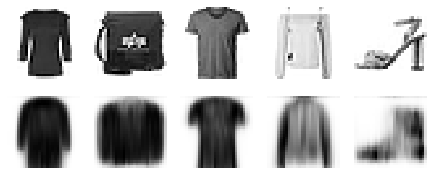

In [21]:
show_reconstructions(recurrent_ae)
plt.show()

## Denoising autoencoders

### Using gaussian noise

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # Add noise to the input
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    # From noisy output to input
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 170us/sample - loss: 0.3494 - rounded_accuracy: 0.8779 - val_loss: 0.3163 - val_rounded_accuracy: 0.9075
Epoch 2/10
55000/55000 [==============================] - 10s 185us/sample - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3086 - val_rounded_accuracy: 0.9126
Epoch 3/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.3060 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9150
Epoch 4/10
55000/55000 [==============================] - 9s 162us/sample - loss: 0.3023 - rounded_accuracy: 0.9181 - val_loss: 0.3002 - val_rounded_accuracy: 0.9219
Epoch 5/10
55000/55000 [==============================] - 9s 161us/sample - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2976 - val_rounded_accuracy: 0.9247
Epoch 6/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2977 - rounded_accuracy: 0.9222 - v

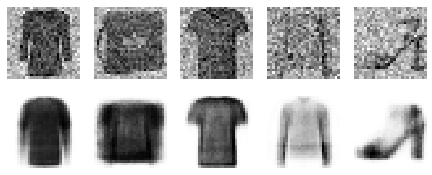

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

### Using dropout

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 152us/sample - loss: 0.3554 - rounded_accuracy: 0.8721 - val_loss: 0.3188 - val_rounded_accuracy: 0.9057
Epoch 2/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3179 - rounded_accuracy: 0.9034 - val_loss: 0.3115 - val_rounded_accuracy: 0.9117
Epoch 3/10
55000/55000 [==============================] - 8s 147us/sample - loss: 0.3124 - rounded_accuracy: 0.9079 - val_loss: 0.3070 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 8s 154us/sample - loss: 0.3089 - rounded_accuracy: 0.9106 - val_loss: 0.3039 - val_rounded_accuracy: 0.9173
Epoch 5/10
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3065 - rounded_accuracy: 0.9126 - val_loss: 0.3016 - val_rounded_accuracy: 0.9198
Epoch 6/10
55000/55000 [==============================] - 8s 147us/sample - loss: 0.3047 - rounded_accuracy: 0.9141 - val

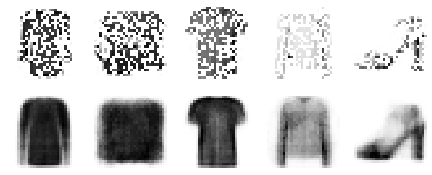

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

## Sparse autoencoders

In [27]:
# First a simple encoder to compare to sparse ones
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 11s 196us/sample - loss: 0.4326 - rounded_accuracy: 0.7948 - val_loss: 0.3773 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 9s 166us/sample - loss: 0.3610 - rounded_accuracy: 0.8670 - val_loss: 0.3508 - val_rounded_accuracy: 0.8783
Epoch 3/10
55000/55000 [==============================] - 9s 160us/sample - loss: 0.3402 - rounded_accuracy: 0.8861 - val_loss: 0.3360 - val_rounded_accuracy: 0.8873
Epoch 4/10
55000/55000 [==============================] - 8s 138us/sample - loss: 0.3273 - rounded_accuracy: 0.8968 - val_loss: 0.3248 - val_rounded_accuracy: 0.9007
Epoch 5/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.3207 - rounded_accuracy: 0.9016 - val_loss: 0.3212 - val_rounded_accuracy: 0.9047
Epoch 6/10
55000/55000 [==============================] - 8s 149us/sample - loss: 0.3173 - rounded_accuracy: 0.9041 - va

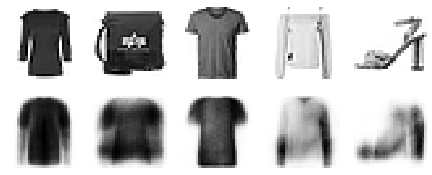

In [28]:
show_reconstructions(simple_ae)
plt.show()

### Activation histograms

In [29]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [30]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

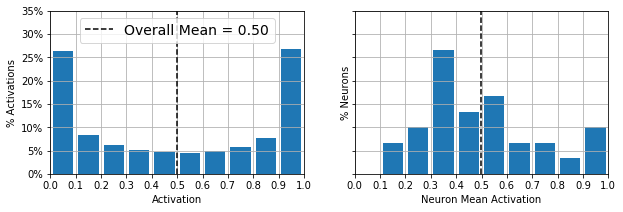

In [31]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

### Add l1 regularization

In [32]:
tf.random.set_seed(42)
np.random.seed(42)
# Encourages network to produce codings close to 0
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 185us/sample - loss: 0.4307 - rounded_accuracy: 0.8133 - val_loss: 0.3801 - val_rounded_accuracy: 0.8590
Epoch 2/10
55000/55000 [==============================] - 8s 154us/sample - loss: 0.3691 - rounded_accuracy: 0.8690 - val_loss: 0.3644 - val_rounded_accuracy: 0.8715
Epoch 3/10
55000/55000 [==============================] - 9s 164us/sample - loss: 0.3554 - rounded_accuracy: 0.8789 - val_loss: 0.3530 - val_rounded_accuracy: 0.8764
Epoch 4/10
55000/55000 [==============================] - 8s 149us/sample - loss: 0.3442 - rounded_accuracy: 0.8870 - val_loss: 0.3426 - val_rounded_accuracy: 0.8881
Epoch 5/10
55000/55000 [==============================] - 9s 157us/sample - loss: 0.3368 - rounded_accuracy: 0.8926 - val_loss: 0.3412 - val_rounded_accuracy: 0.8957
Epoch 6/10
55000/55000 [==============================] - 9s 160us/sample - loss: 0.3307 - rounded_accuracy: 0.8981 - va

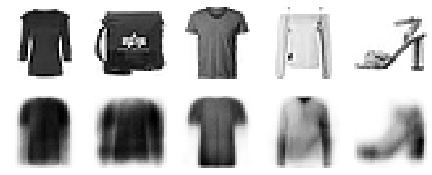

In [33]:
show_reconstructions(sparse_l1_ae)

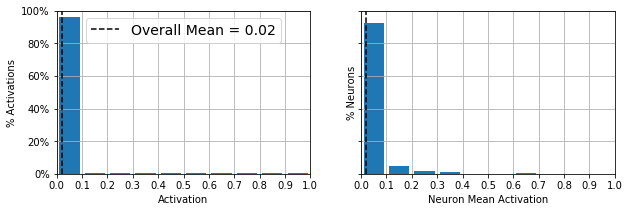

In [34]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

### Using KL Divergence

[0, 1, 0, 0.95]

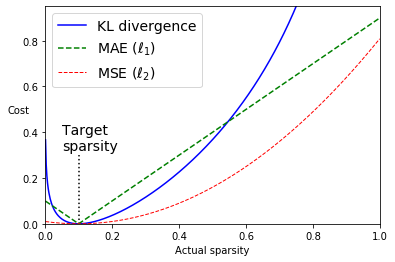

In [36]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [9]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [38]:

tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 190us/sample - loss: 0.4151 - rounded_accuracy: 0.8121 - val_loss: 0.3715 - val_rounded_accuracy: 0.8569
Epoch 2/10
55000/55000 [==============================] - 9s 162us/sample - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3443 - val_rounded_accuracy: 0.8845
Epoch 3/10
55000/55000 [==============================] - 9s 157us/sample - loss: 0.3339 - rounded_accuracy: 0.8920 - val_loss: 0.3292 - val_rounded_accuracy: 0.8964
Epoch 4/10
55000/55000 [==============================] - 9s 162us/sample - loss: 0.3222 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9046
Epoch 5/10
55000/55000 [==============================] - 9s 167us/sample - loss: 0.3169 - rounded_accuracy: 0.9062 - val_loss: 0.3173 - val_rounded_accuracy: 0.9061
Epoch 6/10
55000/55000 [==============================] - 9s 166us/sample - loss: 0.3135 - rounded_accuracy: 0.9093 - va

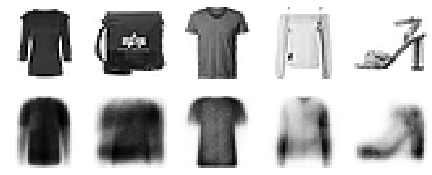

In [39]:
show_reconstructions(sparse_kl_ae)

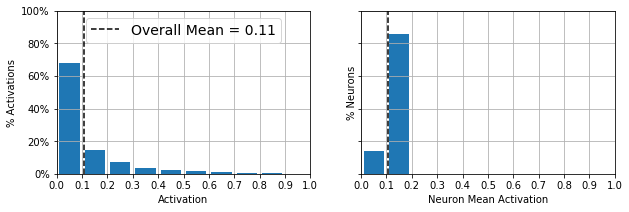

In [41]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

## Variational Autoencoders

In [7]:
# Sample from normal distribution
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
# Output the codings mean and log variance with same input (z) vectors from the encodings latent loss
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
# Encoder has three outputs, in case want to examine codings mean and var
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Only output we will use is the last one (codings)
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# only output the codings of inputs then put into decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# Latent loss equation to put into the model, minimize this to find the codings_log_var and codings_mean vector
# K is keras.backend defined earlier
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 140us/sample - loss: 0.3906 - rounded_accuracy: 0.8599 - val_loss: 0.3575 - val_rounded_accuracy: 0.8821
Epoch 2/25
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3426 - rounded_accuracy: 0.8982 - val_loss: 0.3363 - val_rounded_accuracy: 0.9052
Epoch 3/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3326 - rounded_accuracy: 0.9055 - val_loss: 0.3294 - val_rounded_accuracy: 0.9111
Epoch 4/25
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3276 - rounded_accuracy: 0.9093 - val_loss: 0.3340 - val_rounded_accuracy: 0.9009
Epoch 5/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3244 - rounded_accuracy: 0.9120 - val_loss: 0.3279 - val_rounded_accuracy: 0.9053
Epoch 6/25
55000/55000 [==============================] - 6s 111us/sample - loss: 0.3222 - rounded_accuracy: 0.9139 - val_

### Generate new images

In [11]:

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

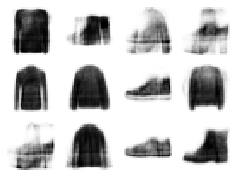

In [17]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

### Semantic interpolation

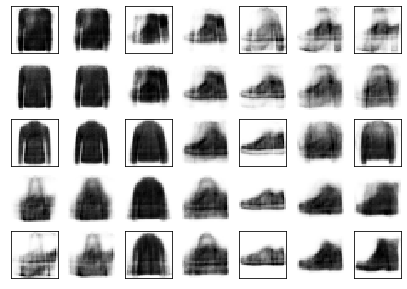

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")


# Generative Adversarial Networks (GANs)

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

# Generator similar to autoencoders decoder
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# Discriminator is basically a binary classifier (fake or not)
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [21]:
# binary classifier, train using binary crossentropy loss.
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
# Discriminator should not be trained during the second phase so make it non-trainable before compiling the GAN model
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Training is not standard, can't use regular fit method

In [22]:
# define a batch size and dataset to iterate through the images 
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [23]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            # Generate gaussian noise of batch_size and set target for these as 0
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            # Set target as 1, make discriminator think it's real
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


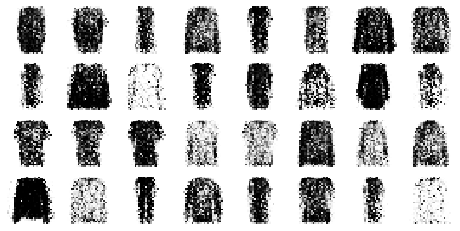

In [24]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

### Improving more than this is challenging, don't get much improvement by increasing epochs
### Can even get worse by forgetting previous instances
### Area of active research, still not well understood

## Deep convolutional GANs

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100
# main guidelines
# Replace any pooling layers with strided convolutions in discriminator and transposed convolutions in generator
# Use batch normalization in both generator and discriminator, except in generator output and discriminator input
# Remove fully connected hidden layers for deeper architectures
# Use ReLU activation in generator for all layers except output which should use tanh
# Use leaky ReLU in discriminator for all layers
# Still need to experiment with them

# takes codings of size 100 and projects to 6272 dimensions (7x7x128) and reshapes to 7x7x128 tensor
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    # Batch normalized and fed to transposed convolutional layer with stride 2 
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [33]:
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [34]:
# Before training the GAN reshape and rescale since the tanh activation requires outputs 
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [35]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/1


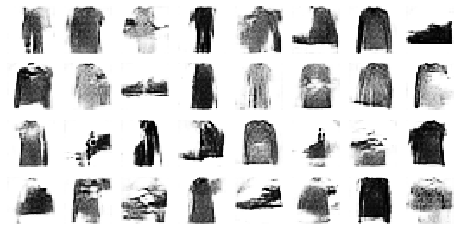

In [36]:
train_gan(gan, dataset, batch_size, codings_size,1)

Can increase epochs to get better representations. Scale up and train on large dataset of faces for fairly realistic images.

### Style GANs
Used in https://thispersondoesnotexist.com/
There are pretrained StyleGANs for Keras